This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
from collections import Counter, defaultdict
if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1

class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 5
    n_splits = 3
    debug = False
    save = False

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

%cd /content/drive/MyDrive/Kaggle/Foursquare/Notebook

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 29.8 MB/s 
/content/drive/MyDrive/Kaggle/Foursquare/Notebook


In [ ]:
OUTPUT_DIR = '../Output'
if not os.path.exists(os.path.join(OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(OUTPUT_DIR, CFG.expID))

In [ ]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [ ]:
if CFG.debug:
    train = train[:10000]

# Devide Train Data into about 600K×2

In [ ]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    for country, country_df in tqdm(df.groupby("country")):
        country_dfs = []
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), CFG.n_neighbors), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        targets = country_df[CFG.target].values
        for i in range(min(len(country_df), CFG.n_neighbors)):
            country_df_ = country_df.copy()
            country_df_[f"d_near"] = dists[:, i]
            country_df_[f"near_target"] = targets[nears[:, i]]
            for c in columns:
                country_df_[f"near_{c}"] = country_df_[c].values[nears[:, i]]
            country_dfs.append(country_df_)
        country_df = pd.concat(country_dfs)
        dfs.append(country_df)
    
    for zip, zip_df in tqdm(df.groupby("zip")):
        zip_dfs = []
        zip_df = zip_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(zip_df), CFG.n_neighbors), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(zip_df[['latitude','longitude']], zip_df.index)
        dists, nears = knn.kneighbors(zip_df[['latitude','longitude']], return_distance=True)
        targets = zip_df[CFG.target].values
        for i in range(min(len(zip_df), CFG.n_neighbors)):
            zip_df_ = zip_df.copy()
            zip_df_[f"d_near"] = dists[:, i]
            zip_df_[f"near_target"] = targets[nears[:, i]]
            for c in columns:
                zip_df_[f"near_{c}"] = zip_df_[c].values[nears[:, i]]
            zip_dfs.append(zip_df_)
        zip_df = pd.concat(zip_dfs)
        dfs.append(zip_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/61745 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/61434 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id,near_name,near_address,near_city,near_state,near_zip,near_country,near_url,near_phone,near_categories
0,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,E_1104d3664585a4,mamá maría,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,nan,"italian restaurants, pizza places"


In [ ]:
train = train[train['id'] != train['near_id']]
test = test[test['id'] != test['near_id']]

In [ ]:
train.drop_duplicates(inplace = True)
test.drop_duplicates(inplace = True)

# Create Target

In [ ]:
train["target"] = 0
train.loc[train[CFG.target]==train[f"near_target"], "target"] = 1
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_name,near_address,near_city,near_state,near_zip,near_country,near_url,near_phone,near_categories,target
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,mamá maría,"av. meritxell, 25",andorra la vella,andorra,ad500,ad,nan,+376869996,"italian restaurants, pizza places",1
13,E_1514d74b987ae1,ahotels piolets park & spa,42.578021,1.663907,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,...,ontbijtroom piolets park,nan,soldeu,andorra,nan,ad,nan,nan,buffets,1
14,E_206f06060f193d,la borda xica,42.571045,1.487248,cap del carrer,la massana,nan,nan,ad,nan,...,vallnord - pal arinsal (sector arinsal),carretera d'arinsal. ed. comallemple.,arinsal,arinsal,ad400,ad,http://www.vallnord.com,737020,ski areas,0
15,E_20b7920b07557d,"escola de esquí el forn de canillo, grandvalira",42.556103,1.616165,"el forn de canillo, s/n",canillo,canillo,ad100,ad,nan,...,el forn de canillo,nan,canillo,nan,nan,ad,nan,nan,ski areas,1
16,E_4a34a5012e88c3,pic negre 11,42.546688,1.513963,nan,la massana,nan,ad400,ad,nan,...,pic negre 12,sanantoni,la massana,nan,ad400,ad,nan,737745,sporting goods shops,0


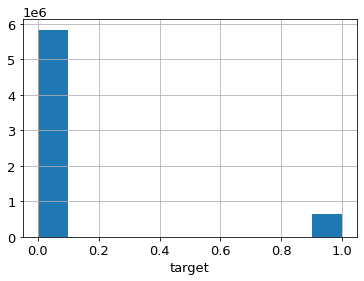

In [ ]:
plt.hist(train["target"])
plt.grid()
plt.xlabel("target")
plt.show()

# Check Maximum Score

In [ ]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

In [ ]:
def get_score(id2ids: dict):
    scores = []
    precisions = []
    recalls = []
    for id_str in train['id'].unique():
        if id_str in id2ids:
            preds = id2ids[id_str]
        else:
            preds = set()
        preds.add(id_str)
        targets = poi2ids[id2poi[id_str]]
        score = len((targets & preds)) / len((targets | preds))
        if len(preds) == 0:
            precision = 0
        else:
            precision = len((targets & preds)) / len(preds)
        recall = len((targets & preds)) / len(targets)
        scores.append(score)
        precisions.append(precision)
        recalls.append(recall)
    scores = np.array(scores)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    return scores.mean(), precisions.mean(), recalls.mean()

In [ ]:
id2ids = train[train[CFG.target] == train['near_target']].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(score)

0.8748423942570767


In [ ]:
# del train
# gc.collect()

# Feature Engineering

In [ ]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

     |████████████████████████████████| 258 kB 27.5 MB/s 
     |████████████████████████████████| 1.8 MB 69.5 MB/s 
     |████████████████████████████████| 103 kB 72.4 MB/s 


In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
import Levenshtein
import difflib

def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for str1, str2 in df[[c, f"near_{c}"]].values.astype(str):
            if str1==str1 and str2==str2:
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))
            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
        df[f"near_{c}_gesh"] = geshs
        df[f"near_{c}_leven"] = levens
        df[f"near_{c}_jaro"] = jaros
        df[f"near_{c}_lcs"] = lcss
        
        if not c in ['country', "phone", "zip"]:
            df[f"{c}_len"] = df[c].astype(str).map(len)
            df[f"near_{c}_len"] = df[f"near_{c}"].astype(str).map(len)
            df[f"near_{c}_nleven"] = df[f"near_{c}_leven"] / df[[f"near_{c}_len", f"{c}_len"]].max(axis=1)
            df[f"near_{c}_nlcsi"] = df[f"near_{c}_lcs"] / df[f"near_{c}_len"]
            df[f"near_{c}_nlcs0"] = df[f"near_{c}_lcs"] / df[f"{c}_len"]
    return df

def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "train_distance_features.csv"))
test_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "test_distance_features.csv"))

if CFG.save and (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train = pd.read_csv(train_distance_features_path)
    test = pd.read_csv(test_distance_features_path)
else:
    train = add_distance_features(train)
    test = add_distance_features(test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
display(train.head(1))
display(test.head(1))

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,0,1.0,0,1.0,33,33,33,0.0,1.0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
12,E_00001118ad0191,jamu petani bagan serai,5.012169,100.535805,nan,nan,nan,nan,my,nan,...,3,0.307692,6,0.55,2,5,8,0.75,0.25,0.4


In [ ]:
if CFG.save and not (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train.to_csv(train_distance_features_path, index=False)
    test.to_csv(test_distance_features_path, index=False)

# Delete Unusing Columns (just for avoiding OOM)

In [ ]:
train['id_pair'] = train[['id', 'near_id']].apply(lambda x: tuple(sorted(list(x))), axis = 1)
test['id_pair'] = test[['id', 'near_id']].apply(lambda x: tuple(sorted(list(x))), axis = 1)

In [ ]:
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0,id_pair
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,1.000000,0,1.000000,33,33,33,0.000000,1.000000,1.000000,"(E_1104d3664585a4, E_be8ec27bf1b71b)"
13,E_1514d74b987ae1,ahotels piolets park & spa,42.578021,1.663907,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,...,0.451613,17,0.406746,7,24,7,0.708333,1.000000,0.291667,"(E_1514d74b987ae1, E_dfa69a18228406)"
14,E_206f06060f193d,la borda xica,42.571045,1.487248,cap del carrer,la massana,nan,nan,ad,nan,...,0.300000,8,0.670034,5,11,9,0.727273,0.555556,0.454545,"(E_206f06060f193d, E_bb40eb6b8aa6c9)"
15,E_20b7920b07557d,"escola de esquí el forn de canillo, grandvalira",42.556103,1.616165,"el forn de canillo, s/n",canillo,canillo,ad100,ad,nan,...,1.000000,0,1.000000,9,9,9,0.000000,1.000000,1.000000,"(E_20b7920b07557d, E_9acdcda349c154)"
16,E_4a34a5012e88c3,pic negre 11,42.546688,1.513963,nan,la massana,nan,ad400,ad,nan,...,1.000000,0,1.000000,20,20,20,0.000000,1.000000,1.000000,"(E_4a34a5012e88c3, E_bc8a2b3674875b)"


In [ ]:
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

features.append(f"d_near")
for c in columns:        
    features += [f"near_{c}_gesh", f"near_{c}_jaro", f"near_{c}_lcs"]
    if c in ['country', "phone", "zip"]:
        features += [f"near_{c}_leven"]
    else:
        features += [f"near_{c}_len", f"near_{c}_nleven", f"near_{c}_nlcsi", f"near_{c}_nlcs0"]

for f in features:
#     assert f in train.columns
    if f not in test.columns:
        test[f] = np.nan

print(features)

['d_near', 'near_name_gesh', 'near_name_jaro', 'near_name_lcs', 'near_name_len', 'near_name_nleven', 'near_name_nlcsi', 'near_name_nlcs0', 'near_address_gesh', 'near_address_jaro', 'near_address_lcs', 'near_address_len', 'near_address_nleven', 'near_address_nlcsi', 'near_address_nlcs0', 'near_city_gesh', 'near_city_jaro', 'near_city_lcs', 'near_city_len', 'near_city_nleven', 'near_city_nlcsi', 'near_city_nlcs0', 'near_state_gesh', 'near_state_jaro', 'near_state_lcs', 'near_state_len', 'near_state_nleven', 'near_state_nlcsi', 'near_state_nlcs0', 'near_zip_gesh', 'near_zip_jaro', 'near_zip_lcs', 'near_zip_leven', 'near_country_gesh', 'near_country_jaro', 'near_country_lcs', 'near_country_leven', 'near_url_gesh', 'near_url_jaro', 'near_url_lcs', 'near_url_len', 'near_url_nleven', 'near_url_nlcsi', 'near_url_nlcs0', 'near_phone_gesh', 'near_phone_jaro', 'near_phone_lcs', 'near_phone_leven', 'near_categories_gesh', 'near_categories_jaro', 'near_categories_lcs', 'near_categories_len', 'near_

In [ ]:
train = train[features + [CFG.target, "target", "id", "near_id", "id_pair"]]
test = test[features + ["id", "near_id", "id_pair"]]

train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468465 entries, 0 to 6468464
Data columns (total 60 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   d_near                  float16
 1   near_name_gesh          float16
 2   near_name_jaro          float16
 3   near_name_lcs           float16
 4   near_name_len           float16
 5   near_name_nleven        float16
 6   near_name_nlcsi         float16
 7   near_name_nlcs0         float16
 8   near_address_gesh       float16
 9   near_address_jaro       float16
 10  near_address_lcs        float16
 11  near_address_len        float16
 12  near_address_nleven     float16
 13  near_address_nlcsi      float16
 14  near_address_nlcs0      float16
 15  near_city_gesh          float16
 16  near_city_jaro          float16
 17  near_city_lcs           float16
 18  near_city_len           float16
 19  near_city_nleven        float16
 20  near_city_nlcsi         float16
 21  near_city_nlcs0         float16

# Split Folds

In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
distrs = [get_distribution(train["target"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train, train["target"], train["id_pair"], k=CFG.n_splits, seed=CFG.seed)):
    train.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train.loc[dev_ind, "target"], train.loc[val_ind, "target"]
    dev_groups, val_groups = train.loc[dev_ind, "id_pair"], train.loc[val_ind, "id_pair"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train["target"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,90.26%,9.74%
development set - fold 0,90.26%,9.74%
validation set - fold 0,90.26%,9.74%
development set - fold 1,90.26%,9.74%
validation set - fold 1,90.26%,9.74%
development set - fold 2,90.26%,9.74%
validation set - fold 2,90.26%,9.74%


# Model Learning

In [ ]:
import lightgbm as lgbm

def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

if os.path.exists(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, 'lgbm_fold0.pkl'))):
    models = [joblib.load(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))) for i in range(CFG.n_splits)]
    oof = pd.read_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")))
    oof = oof.values
else:
    oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                          params=params, n_class=2, 
                          N_SPLITS=CFG.n_splits, folds=train["fold"].values)
    pd.DataFrame(oof).to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")), index = False)
pred = inference_lgbm(models, test[features])

  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's binary_logloss: 0.101647
[100]	valid_0's binary_logloss: 0.0980015
[150]	valid_0's binary_logloss: 0.0962679
[200]	valid_0's binary_logloss: 0.0951752
[250]	valid_0's binary_logloss: 0.0945604
[300]	valid_0's binary_logloss: 0.0940375
[350]	valid_0's binary_logloss: 0.0935258
[400]	valid_0's binary_logloss: 0.0932106
[450]	valid_0's binary_logloss: 0.0928653
[500]	valid_0's binary_logloss: 0.0925727
[550]	valid_0's binary_logloss: 0.0923203
[600]	valid_0's binary_logloss: 0.0921276
[650]	valid_0's binary_logloss: 0.0919472
[700]	valid_0's binary_logloss: 0.0917474
[750]	valid_0's binary_logloss: 0.0915625
[800]	valid_0's binary_logloss: 0.0914338
[850]	valid_0's binary_logloss: 0.0913291
[900]	valid_0's binary_logloss: 0.0912479
[950]	valid_0's binary_logloss: 0.0911376
[1000]	valid_0's binary_logloss: 0.0910781
[1050]	valid_0's binary_logloss: 0.0909993
[1100]	valid_0's binary_logloss: 0.0909116
[1150]	valid_0's binary_logloss: 0.0908
[1200]	valid_0's binar

In [ ]:
train["pred"] = oof[:, -1]

# Check CV

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 27.5 MB/s 
     |████████████████████████████████| 81 kB 11.3 MB/s 
     |████████████████████████████████| 210 kB 57.8 MB/s 
     |████████████████████████████████| 78 kB 7.9 MB/s 
     |████████████████████████████████| 146 kB 74.6 MB/s 
     |████████████████████████████████| 49 kB 7.2 MB/s 
     |████████████████████████████████| 112 kB 71.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=fe505998653dc9dbefe63ce06d9c48b0629d0b1b80757834704daf1cd074cd64
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-16 16:35:17,741] A new study created in memory with name: no-name-8ba36a29-1576-49cb-8064-65924e1a75d8
[I 2022-05-16 16:35:37,789] Trial 0 finished with value: 0.8028111053129756 and parameters: {'threshold': 0.26841733649347355}. Best is trial 0 with value: 0.8028111053129756.


CV: 0.802811, precision: 0.942482, recall: 0.851363


[I 2022-05-16 16:35:56,883] Trial 1 finished with value: 0.8101916451455202 and parameters: {'threshold': 0.48146988936089274}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.810192, precision: 0.969431, recall: 0.836044


[I 2022-05-16 16:36:11,966] Trial 2 finished with value: 0.7756602013983305 and parameters: {'threshold': 0.8841086591550995}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.775660, precision: 0.994784, recall: 0.780005


[I 2022-05-16 16:36:36,218] Trial 3 finished with value: 0.7600869739031503 and parameters: {'threshold': 0.08299615607303035}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.760087, precision: 0.873868, recall: 0.864428


[I 2022-05-16 16:36:53,143] Trial 4 finished with value: 0.8090936741846824 and parameters: {'threshold': 0.5567996024330143}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.809094, precision: 0.975748, recall: 0.829574


[I 2022-05-16 16:37:09,303] Trial 5 finished with value: 0.7881144573846673 and parameters: {'threshold': 0.8242573619084321}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.788114, precision: 0.992037, recall: 0.794779


[I 2022-05-16 16:37:35,479] Trial 6 finished with value: 0.7244130770482724 and parameters: {'threshold': 0.04291200644319715}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.724413, precision: 0.823781, recall: 0.868150


[I 2022-05-16 16:37:49,366] Trial 7 finished with value: 0.7792204698026417 and parameters: {'threshold': 0.8701052627319287}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.779220, precision: 0.994160, recall: 0.784084


[I 2022-05-16 16:38:12,717] Trial 8 finished with value: 0.772445279855657 and parameters: {'threshold': 0.10897641938740665}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.772445, precision: 0.891959, recall: 0.862373


[I 2022-05-16 16:38:27,241] Trial 9 finished with value: 0.7868079655752548 and parameters: {'threshold': 0.8320200741543474}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.786808, precision: 0.992402, recall: 0.793165


[I 2022-05-16 16:38:45,797] Trial 10 finished with value: 0.8096662445103745 and parameters: {'threshold': 0.5308099378880553}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.809666, precision: 0.973701, recall: 0.831881


[I 2022-05-16 16:39:03,109] Trial 11 finished with value: 0.810035903338933 and parameters: {'threshold': 0.5081033556025275}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.810036, precision: 0.971845, recall: 0.833830


[I 2022-05-16 16:39:23,012] Trial 12 finished with value: 0.8090323671958942 and parameters: {'threshold': 0.38313699824846487}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.809032, precision: 0.959215, recall: 0.843539


[I 2022-05-16 16:39:40,403] Trial 13 finished with value: 0.8021411286666336 and parameters: {'threshold': 0.698784731533128}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.802141, precision: 0.985359, recall: 0.814470


[I 2022-05-16 16:39:58,841] Trial 14 finished with value: 0.8090439359440049 and parameters: {'threshold': 0.38337774689824766}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.809044, precision: 0.959245, recall: 0.843526


[I 2022-05-16 16:40:16,457] Trial 15 finished with value: 0.8047187683602686 and parameters: {'threshold': 0.6607728878979489}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.804719, precision: 0.983040, recall: 0.818993


[I 2022-05-16 16:40:36,315] Trial 16 finished with value: 0.8088308725597128 and parameters: {'threshold': 0.37720470092607633}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.808831, precision: 0.958500, recall: 0.843947


[I 2022-05-16 16:40:57,466] Trial 17 finished with value: 0.8020830424507247 and parameters: {'threshold': 0.2597966224517031}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.802083, precision: 0.940908, recall: 0.851944


[I 2022-05-16 16:41:13,339] Trial 18 finished with value: 0.8039025963066934 and parameters: {'threshold': 0.6732827995670382}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.803903, precision: 0.983791, recall: 0.817546


[I 2022-05-16 16:41:32,687] Trial 19 finished with value: 0.8101907664589046 and parameters: {'threshold': 0.45715689042801066}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.810191, precision: 0.967157, recall: 0.837986


[I 2022-05-16 16:41:43,002] Trial 20 finished with value: 0.7181012559618314 and parameters: {'threshold': 0.9803942802193759}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.718101, precision: 0.999164, recall: 0.718788


[I 2022-05-16 16:42:02,509] Trial 21 finished with value: 0.8100852197981554 and parameters: {'threshold': 0.43575136317488694}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.810085, precision: 0.965011, recall: 0.839679


[I 2022-05-16 16:42:21,965] Trial 22 finished with value: 0.8028273254870056 and parameters: {'threshold': 0.2685508557935177}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.802827, precision: 0.942509, recall: 0.851355


[I 2022-05-16 16:42:41,359] Trial 23 finished with value: 0.8096136831258108 and parameters: {'threshold': 0.40907955251992156}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.809614, precision: 0.962155, recall: 0.841633


[I 2022-05-16 16:42:59,486] Trial 24 finished with value: 0.8080329762234998 and parameters: {'threshold': 0.5927192792710563}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.808033, precision: 0.978500, recall: 0.826158


[I 2022-05-16 16:43:17,214] Trial 25 finished with value: 0.8101603469319406 and parameters: {'threshold': 0.44755453013005225}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.810160, precision: 0.966214, recall: 0.838749


[I 2022-05-16 16:43:38,826] Trial 26 finished with value: 0.794558427513578 and parameters: {'threshold': 0.19748935705153647}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.794558, precision: 0.926807, recall: 0.856127


[I 2022-05-16 16:43:56,596] Trial 27 finished with value: 0.8071273168923646 and parameters: {'threshold': 0.6151913322441239}. Best is trial 1 with value: 0.8101916451455202.


CV: 0.807127, precision: 0.980054, recall: 0.823937


[I 2022-05-16 16:44:15,604] Trial 28 finished with value: 0.8102430217778943 and parameters: {'threshold': 0.4737428857426066}. Best is trial 28 with value: 0.8102430217778943.


CV: 0.810243, precision: 0.968723, recall: 0.836692


[I 2022-05-16 16:44:34,777] Trial 29 finished with value: 0.8053887067607481 and parameters: {'threshold': 0.3031659456711928}. Best is trial 28 with value: 0.8102430217778943.


CV: 0.805389, precision: 0.948305, recall: 0.849045


[I 2022-05-16 16:44:51,533] Trial 30 finished with value: 0.7986457045076494 and parameters: {'threshold': 0.7389339428238297}. Best is trial 28 with value: 0.8102430217778943.


CV: 0.798646, precision: 0.987651, recall: 0.809022


[I 2022-05-16 16:45:10,762] Trial 31 finished with value: 0.8102342192258146 and parameters: {'threshold': 0.4624809367038024}. Best is trial 28 with value: 0.8102430217778943.


CV: 0.810234, precision: 0.967676, recall: 0.837585


[I 2022-05-16 16:45:28,353] Trial 32 finished with value: 0.8101612703085569 and parameters: {'threshold': 0.48677116384366326}. Best is trial 28 with value: 0.8102430217778943.


CV: 0.810161, precision: 0.969925, recall: 0.835604


[I 2022-05-16 16:45:48,577] Trial 33 finished with value: 0.8075770311069612 and parameters: {'threshold': 0.3430970415018554}. Best is trial 28 with value: 0.8102430217778943.


CV: 0.807577, precision: 0.954138, recall: 0.846343


[I 2022-05-16 16:46:07,811] Trial 34 finished with value: 0.8102501400327156 and parameters: {'threshold': 0.4726235426473582}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.810250, precision: 0.968619, recall: 0.836784


[I 2022-05-16 16:46:24,814] Trial 35 finished with value: 0.809136695384229 and parameters: {'threshold': 0.5554254033265995}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.809137, precision: 0.975655, recall: 0.829695


[I 2022-05-16 16:46:43,060] Trial 36 finished with value: 0.8076953963815561 and parameters: {'threshold': 0.6010894973947051}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.807695, precision: 0.979087, recall: 0.825327


[I 2022-05-16 16:47:05,124] Trial 37 finished with value: 0.7922357077448615 and parameters: {'threshold': 0.1835271069323306}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.792236, precision: 0.922876, recall: 0.857049


[I 2022-05-16 16:47:24,157] Trial 38 finished with value: 0.8101827327690959 and parameters: {'threshold': 0.4857324485869265}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.810183, precision: 0.969832, recall: 0.835702


[I 2022-05-16 16:47:39,710] Trial 39 finished with value: 0.7959584434495813 and parameters: {'threshold': 0.7649862406985524}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.795958, precision: 0.989021, recall: 0.805169


[I 2022-05-16 16:47:58,131] Trial 40 finished with value: 0.8091977346615685 and parameters: {'threshold': 0.5533287762317998}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.809198, precision: 0.975493, recall: 0.829897


[I 2022-05-16 16:48:15,828] Trial 41 finished with value: 0.8101933078127138 and parameters: {'threshold': 0.4509016062607202}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.810193, precision: 0.966552, recall: 0.838497


[I 2022-05-16 16:48:35,989] Trial 42 finished with value: 0.8065629381340528 and parameters: {'threshold': 0.3227307130232989}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.806563, precision: 0.951294, recall: 0.847714


[I 2022-05-16 16:48:54,607] Trial 43 finished with value: 0.8099300522362777 and parameters: {'threshold': 0.5154625765813806}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.809930, precision: 0.972472, recall: 0.833187


[I 2022-05-16 16:49:12,549] Trial 44 finished with value: 0.809807483950578 and parameters: {'threshold': 0.41937160003330853}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.809807, precision: 0.963231, recall: 0.840905


[I 2022-05-16 16:49:31,517] Trial 45 finished with value: 0.8102465602218233 and parameters: {'threshold': 0.47273560445299834}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.810247, precision: 0.968628, recall: 0.836774


[I 2022-05-16 16:49:49,485] Trial 46 finished with value: 0.8064534067966932 and parameters: {'threshold': 0.6291839995339333}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.806453, precision: 0.980983, recall: 0.822467


[I 2022-05-16 16:50:08,088] Trial 47 finished with value: 0.8082924400778955 and parameters: {'threshold': 0.3605763027022931}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.808292, precision: 0.956452, recall: 0.845111


[I 2022-05-16 16:50:26,970] Trial 48 finished with value: 0.8102349958687066 and parameters: {'threshold': 0.4779749905496933}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.810235, precision: 0.969119, recall: 0.836353


[I 2022-05-16 16:50:45,658] Trial 49 finished with value: 0.8099771999205538 and parameters: {'threshold': 0.5124105820090021}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.809977, precision: 0.972213, recall: 0.833449


[I 2022-05-16 16:51:02,258] Trial 50 finished with value: 0.8081711259466957 and parameters: {'threshold': 0.5884469403380497}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.808171, precision: 0.978186, recall: 0.826568


[I 2022-05-16 16:51:21,284] Trial 51 finished with value: 0.810218766834916 and parameters: {'threshold': 0.46135055393294266}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.810219, precision: 0.967560, recall: 0.837665


[I 2022-05-16 16:51:41,034] Trial 52 finished with value: 0.8094213757557144 and parameters: {'threshold': 0.39812870325997135}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.809421, precision: 0.960963, recall: 0.842452


[I 2022-05-16 16:51:58,345] Trial 53 finished with value: 0.8094798605865794 and parameters: {'threshold': 0.5409155675326666}. Best is trial 34 with value: 0.8102501400327156.


CV: 0.809480, precision: 0.974536, recall: 0.830989


[I 2022-05-16 16:52:17,150] Trial 54 finished with value: 0.810254407780773 and parameters: {'threshold': 0.47148122454485913}. Best is trial 54 with value: 0.810254407780773.


CV: 0.810254, precision: 0.968521, recall: 0.836874
CV: 0.250806, precision: 0.267602, recall: 0.874839


[I 2022-05-16 16:53:01,296] Trial 55 finished with value: 0.25080572455709227 and parameters: {'threshold': 1.7644122287774344e-05}. Best is trial 54 with value: 0.810254407780773.
[I 2022-05-16 16:53:18,482] Trial 56 finished with value: 0.8101842411480729 and parameters: {'threshold': 0.48491151166072166}. Best is trial 54 with value: 0.810254407780773.


CV: 0.810184, precision: 0.969759, recall: 0.835763


[I 2022-05-16 16:53:37,817] Trial 57 finished with value: 0.8096681162839199 and parameters: {'threshold': 0.41218511972387584}. Best is trial 54 with value: 0.810254407780773.


CV: 0.809668, precision: 0.962485, recall: 0.841405


[I 2022-05-16 16:53:55,325] Trial 58 finished with value: 0.8055242159362418 and parameters: {'threshold': 0.6464059002451852}. Best is trial 54 with value: 0.810254407780773.


CV: 0.805524, precision: 0.982110, recall: 0.820591


[I 2022-05-16 16:54:12,117] Trial 59 finished with value: 0.80873101315412 and parameters: {'threshold': 0.570853632140318}. Best is trial 54 with value: 0.810254407780773.


CV: 0.808731, precision: 0.976861, recall: 0.828250


[I 2022-05-16 16:54:32,966] Trial 60 finished with value: 0.8036969097133772 and parameters: {'threshold': 0.2793048793362982}. Best is trial 54 with value: 0.810254407780773.


CV: 0.803697, precision: 0.944409, recall: 0.850641


[I 2022-05-16 16:54:52,023] Trial 61 finished with value: 0.8102393965269655 and parameters: {'threshold': 0.4648173322178849}. Best is trial 54 with value: 0.810254407780773.


CV: 0.810239, precision: 0.967894, recall: 0.837404


[I 2022-05-16 16:55:10,497] Trial 62 finished with value: 0.8086589095156034 and parameters: {'threshold': 0.3716479099173694}. Best is trial 54 with value: 0.810254407780773.


CV: 0.808659, precision: 0.957821, recall: 0.844343


[I 2022-05-16 16:55:29,105] Trial 63 finished with value: 0.8098298584479457 and parameters: {'threshold': 0.521591041197751}. Best is trial 54 with value: 0.810254407780773.


CV: 0.809830, precision: 0.972975, recall: 0.832661


[I 2022-05-16 16:55:48,524] Trial 64 finished with value: 0.8100446737379919 and parameters: {'threshold': 0.4328536496123463}. Best is trial 54 with value: 0.810254407780773.


CV: 0.810045, precision: 0.964696, recall: 0.839902


[I 2022-05-16 16:56:06,259] Trial 65 finished with value: 0.8102561034267267 and parameters: {'threshold': 0.4676681403460185}. Best is trial 65 with value: 0.8102561034267267.


CV: 0.810256, precision: 0.968170, recall: 0.837179


[I 2022-05-16 16:56:25,059] Trial 66 finished with value: 0.8101248686754479 and parameters: {'threshold': 0.49357671021841387}. Best is trial 65 with value: 0.8102561034267267.


CV: 0.810125, precision: 0.970537, recall: 0.835048


[I 2022-05-16 16:56:43,860] Trial 67 finished with value: 0.8074936244568747 and parameters: {'threshold': 0.3414395808474991}. Best is trial 65 with value: 0.8102561034267267.


CV: 0.807494, precision: 0.953907, recall: 0.846452


[I 2022-05-16 16:57:02,274] Trial 68 finished with value: 0.8096044029164222 and parameters: {'threshold': 0.5336338496517176}. Best is trial 65 with value: 0.8102561034267267.


CV: 0.809604, precision: 0.973927, recall: 0.831630


[I 2022-05-16 16:57:21,787] Trial 69 finished with value: 0.809426488881397 and parameters: {'threshold': 0.3989357267882324}. Best is trial 65 with value: 0.8102561034267267.


CV: 0.809426, precision: 0.961043, recall: 0.842393


[I 2022-05-16 16:57:40,819] Trial 70 finished with value: 0.8102683556883022 and parameters: {'threshold': 0.46921286083670843}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.810268, precision: 0.968323, recall: 0.837058


[I 2022-05-16 16:57:58,418] Trial 71 finished with value: 0.8102494807509046 and parameters: {'threshold': 0.4666783466819351}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.810249, precision: 0.968069, recall: 0.837261


[I 2022-05-16 16:58:17,601] Trial 72 finished with value: 0.8101143873261807 and parameters: {'threshold': 0.44233743127616637}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.810114, precision: 0.965688, recall: 0.839145


[I 2022-05-16 16:58:35,908] Trial 73 finished with value: 0.8087016908411967 and parameters: {'threshold': 0.5718071621549152}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.808702, precision: 0.976931, recall: 0.828162


[I 2022-05-16 16:58:53,727] Trial 74 finished with value: 0.8099087422981361 and parameters: {'threshold': 0.4237261851371389}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.809909, precision: 0.963726, recall: 0.840588


[I 2022-05-16 16:59:12,312] Trial 75 finished with value: 0.8100433014707695 and parameters: {'threshold': 0.5067150857033753}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.810043, precision: 0.971726, recall: 0.833939


[I 2022-05-16 16:59:29,872] Trial 76 finished with value: 0.8102653845015202 and parameters: {'threshold': 0.47113913733832496}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.810265, precision: 0.968489, recall: 0.836911


[I 2022-05-16 16:59:47,072] Trial 77 finished with value: 0.8026195691576127 and parameters: {'threshold': 0.6920009735548734}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.802620, precision: 0.984949, recall: 0.815294


[I 2022-05-16 17:00:05,785] Trial 78 finished with value: 0.8094788489097157 and parameters: {'threshold': 0.5407070673309216}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.809479, precision: 0.974513, recall: 0.831009


[I 2022-05-16 17:00:24,099] Trial 79 finished with value: 0.8090656464724595 and parameters: {'threshold': 0.3848801528140533}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.809066, precision: 0.959408, recall: 0.843409


[I 2022-05-16 17:00:44,424] Trial 80 finished with value: 0.8067728539682691 and parameters: {'threshold': 0.3262694628342674}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.806773, precision: 0.951811, recall: 0.847484


[I 2022-05-16 17:01:03,664] Trial 81 finished with value: 0.8102402292405106 and parameters: {'threshold': 0.46548492137681446}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.810240, precision: 0.967958, recall: 0.837350


[I 2022-05-16 17:01:23,431] Trial 82 finished with value: 0.8100761727663973 and parameters: {'threshold': 0.4373074863405924}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.810076, precision: 0.965169, recall: 0.839537


[I 2022-05-16 17:01:41,392] Trial 83 finished with value: 0.8101285006510268 and parameters: {'threshold': 0.4978949199836426}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.810129, precision: 0.970952, recall: 0.834693


[I 2022-05-16 17:02:00,518] Trial 84 finished with value: 0.8102190950800732 and parameters: {'threshold': 0.46138666288104047}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.810219, precision: 0.967562, recall: 0.837664


[I 2022-05-16 17:02:20,599] Trial 85 finished with value: 0.8080227563209232 and parameters: {'threshold': 0.3547712556036018}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.808023, precision: 0.955688, recall: 0.845491


[I 2022-05-16 17:02:29,184] Trial 86 finished with value: 0.6942320945068392 and parameters: {'threshold': 0.9919641399075809}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.694232, precision: 0.999673, recall: 0.694500


[I 2022-05-16 17:02:45,972] Trial 87 finished with value: 0.8087934324682801 and parameters: {'threshold': 0.5688084767280446}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.808793, precision: 0.976708, recall: 0.828443


[I 2022-05-16 17:03:04,863] Trial 88 finished with value: 0.8102362901043878 and parameters: {'threshold': 0.478048970000234}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.810236, precision: 0.969127, recall: 0.836348


[I 2022-05-16 17:03:24,278] Trial 89 finished with value: 0.8095754663933151 and parameters: {'threshold': 0.4080701101826357}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.809575, precision: 0.962031, recall: 0.841702


[I 2022-05-16 17:03:41,373] Trial 90 finished with value: 0.8098098328777555 and parameters: {'threshold': 0.522499106593975}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.809810, precision: 0.973043, recall: 0.832584


[I 2022-05-16 17:04:00,603] Trial 91 finished with value: 0.8102295553255014 and parameters: {'threshold': 0.4630249093349164}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.810230, precision: 0.967726, recall: 0.837538


[I 2022-05-16 17:04:19,925] Trial 92 finished with value: 0.8100762089446539 and parameters: {'threshold': 0.43746646899333413}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.810076, precision: 0.965185, recall: 0.839525


[I 2022-05-16 17:04:37,485] Trial 93 finished with value: 0.8102487118491423 and parameters: {'threshold': 0.47249730228351833}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.810249, precision: 0.968608, recall: 0.836793


[I 2022-05-16 17:04:56,130] Trial 94 finished with value: 0.8100433014707695 and parameters: {'threshold': 0.5067187853815376}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.810043, precision: 0.971726, recall: 0.833939


[I 2022-05-16 17:05:15,876] Trial 95 finished with value: 0.8091334042698635 and parameters: {'threshold': 0.38679252339240217}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.809133, precision: 0.959639, recall: 0.843282


[I 2022-05-16 17:05:32,322] Trial 96 finished with value: 0.8073853473593011 and parameters: {'threshold': 0.6090974155955633}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.807385, precision: 0.979639, recall: 0.824544


[I 2022-05-16 17:05:50,608] Trial 97 finished with value: 0.8093836582891694 and parameters: {'threshold': 0.5457113114396164}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.809384, precision: 0.974912, recall: 0.830583


[I 2022-05-16 17:06:10,233] Trial 98 finished with value: 0.8098148424791982 and parameters: {'threshold': 0.4203392372022602}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.809815, precision: 0.963330, recall: 0.840833


[I 2022-05-16 17:06:27,624] Trial 99 finished with value: 0.810232865160462 and parameters: {'threshold': 0.4790151985712348}. Best is trial 70 with value: 0.8102683556883022.


CV: 0.810233, precision: 0.969217, recall: 0.836267


In [ ]:
threshold = study.best_params['threshold']
threshold

0.46921286083670843

In [ ]:
study.best_value

0.8102683556883022

In [ ]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

CV: 0.810268, precision: 0.968323, recall: 0.837058


# Check Feature Importances

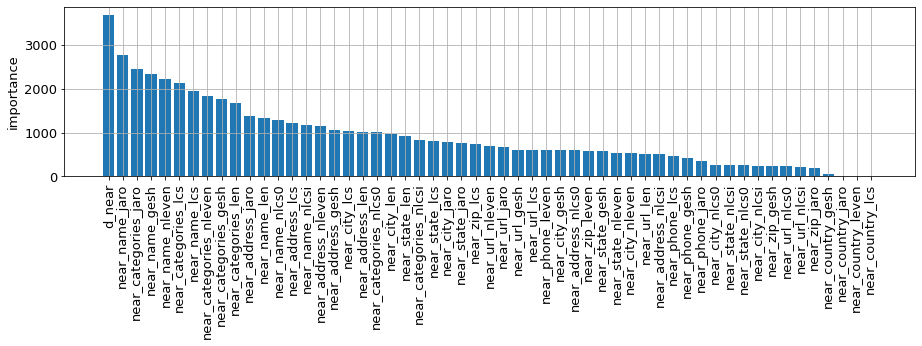

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [ ]:
import optuna
from copy import deepcopy

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    train["matches"] = train["id"]
    if len(id2ids) > 0:
        train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
    id2match = dict(zip(train["id"].values, train["matches"].str.split()))

    for match in tqdm(train["matches"]):
        match = match.split()
        if len(match) == 1:
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    id2ids = deepcopy(id2match)
    for id, ids in id2ids.items():
        id2ids[id] = set(ids)
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-16 17:06:47,840] A new study created in memory with name: no-name-7a4ef016-051f-49df-9548-ba202c0280ec


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:07:35,798] Trial 0 finished with value: 0.8025368780569022 and parameters: {'threshold': 0.7931764629308918}. Best is trial 0 with value: 0.8025368780569022.


CV: 0.802537, precision: 0.988156, recall: 0.812482


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:08:30,342] Trial 1 finished with value: 0.8115856749715726 and parameters: {'threshold': 0.34877403687437647}. Best is trial 1 with value: 0.8115856749715726.


CV: 0.811586, precision: 0.945789, recall: 0.857754


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:09:15,296] Trial 2 finished with value: 0.785592040560918 and parameters: {'threshold': 0.8859056454815515}. Best is trial 1 with value: 0.8115856749715726.


CV: 0.785592, precision: 0.993563, recall: 0.790957


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:10:13,536] Trial 3 finished with value: 0.774411478534019 and parameters: {'threshold': 0.12647458577467352}. Best is trial 1 with value: 0.8115856749715726.


CV: 0.774411, precision: 0.883667, recall: 0.872567


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:11:04,893] Trial 4 finished with value: 0.8156879834888422 and parameters: {'threshold': 0.5996448382868288}. Best is trial 4 with value: 0.8156879834888422.


CV: 0.815688, precision: 0.974302, recall: 0.837491


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.810642, precision: 0.943525, recall: 0.858722


[I 2022-05-16 17:11:57,809] Trial 5 finished with value: 0.810641834102072 and parameters: {'threshold': 0.33453451831222103}. Best is trial 4 with value: 0.8156879834888422.


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.800855, precision: 0.924626, recall: 0.864928


[I 2022-05-16 17:12:52,880] Trial 6 finished with value: 0.8008545109100006 and parameters: {'threshold': 0.2393806448022089}. Best is trial 4 with value: 0.8156879834888422.


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.816677, precision: 0.965632, recall: 0.845909


[I 2022-05-16 17:13:42,363] Trial 7 finished with value: 0.8166770761170375 and parameters: {'threshold': 0.5064692241619586}. Best is trial 7 with value: 0.8166770761170375.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:14:34,749] Trial 8 finished with value: 0.8165400207739234 and parameters: {'threshold': 0.5504849264407262}. Best is trial 7 with value: 0.8166770761170375.


CV: 0.816540, precision: 0.969846, recall: 0.842158


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:15:25,843] Trial 9 finished with value: 0.8130784195118866 and parameters: {'threshold': 0.37479894416348614}. Best is trial 7 with value: 0.8166770761170375.


CV: 0.813078, precision: 0.949693, recall: 0.855950


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:16:12,847] Trial 10 finished with value: 0.8088194793755605 and parameters: {'threshold': 0.7307668902138091}. Best is trial 7 with value: 0.8166770761170375.


CV: 0.808819, precision: 0.984172, recall: 0.822174


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:17:03,369] Trial 11 finished with value: 0.816551817239426 and parameters: {'threshold': 0.5465684922839465}. Best is trial 7 with value: 0.8166770761170375.


CV: 0.816552, precision: 0.969489, recall: 0.842478


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.814330, precision: 0.977480, recall: 0.833383


[I 2022-05-16 17:17:54,216] Trial 12 finished with value: 0.8143298528430547 and parameters: {'threshold': 0.6390052887363887}. Best is trial 7 with value: 0.8166770761170375.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:18:44,182] Trial 13 finished with value: 0.8159759875551146 and parameters: {'threshold': 0.456202949567656}. Best is trial 7 with value: 0.8166770761170375.


CV: 0.815976, precision: 0.960113, recall: 0.849967


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:19:52,806] Trial 14 finished with value: 0.6639883375491211 and parameters: {'threshold': 0.023808629525464586}. Best is trial 7 with value: 0.8166770761170375.


CV: 0.663988, precision: 0.735912, recall: 0.881743


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:20:29,543] Trial 15 finished with value: 0.7014071066359985 and parameters: {'threshold': 0.9916000867265131}. Best is trial 7 with value: 0.8166770761170375.


CV: 0.701407, precision: 0.999553, recall: 0.701773


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.816651, precision: 0.964796, recall: 0.846610


[I 2022-05-16 17:21:21,155] Trial 16 finished with value: 0.8166513242705608 and parameters: {'threshold': 0.4984779610407258}. Best is trial 7 with value: 0.8166770761170375.


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.815715, precision: 0.958632, recall: 0.850969


[I 2022-05-16 17:22:11,433] Trial 17 finished with value: 0.8157148610665047 and parameters: {'threshold': 0.44347895369567025}. Best is trial 7 with value: 0.8166770761170375.


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.812163, precision: 0.980778, recall: 0.828394


[I 2022-05-16 17:22:59,085] Trial 18 finished with value: 0.8121631794214212 and parameters: {'threshold': 0.6825885834204451}. Best is trial 7 with value: 0.8166770761170375.


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.803056, precision: 0.928426, recall: 0.863923


[I 2022-05-16 17:23:54,158] Trial 19 finished with value: 0.8030555739153803 and parameters: {'threshold': 0.2549621713104312}. Best is trial 7 with value: 0.8166770761170375.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:24:42,321] Trial 20 finished with value: 0.8031056275036539 and parameters: {'threshold': 0.7885170278638072}. Best is trial 7 with value: 0.8166770761170375.


CV: 0.803106, precision: 0.987867, recall: 0.813303


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.816585, precision: 0.964478, recall: 0.846821


[I 2022-05-16 17:25:33,107] Trial 21 finished with value: 0.8165853951796088 and parameters: {'threshold': 0.495877326636366}. Best is trial 7 with value: 0.8166770761170375.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:26:24,375] Trial 22 finished with value: 0.8166800284101485 and parameters: {'threshold': 0.5093806526328777}. Best is trial 22 with value: 0.8166800284101485.


CV: 0.816680, precision: 0.965933, recall: 0.845647


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:27:14,650] Trial 23 finished with value: 0.8156901562793528 and parameters: {'threshold': 0.4411690814531797}. Best is trial 22 with value: 0.8166800284101485.


CV: 0.815690, precision: 0.958371, recall: 0.851164


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:28:06,195] Trial 24 finished with value: 0.8160881910238005 and parameters: {'threshold': 0.5821003529124524}. Best is trial 22 with value: 0.8166800284101485.


CV: 0.816088, precision: 0.972760, recall: 0.839203


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:29:00,271] Trial 25 finished with value: 0.801784743074925 and parameters: {'threshold': 0.2458007505578595}. Best is trial 22 with value: 0.8166800284101485.


CV: 0.801785, precision: 0.926238, recall: 0.864498


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.812570, precision: 0.980254, recall: 0.829249


[I 2022-05-16 17:29:48,664] Trial 26 finished with value: 0.8125695017695317 and parameters: {'threshold': 0.6755349469280779}. Best is trial 22 with value: 0.8166800284101485.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:30:39,292] Trial 27 finished with value: 0.8166893724697676 and parameters: {'threshold': 0.5082174741098966}. Best is trial 27 with value: 0.8166893724697676.


CV: 0.816689, precision: 0.965810, recall: 0.845766


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:31:32,347] Trial 28 finished with value: 0.8132778374187164 and parameters: {'threshold': 0.3782161079154721}. Best is trial 27 with value: 0.8166893724697676.


CV: 0.813278, precision: 0.950199, recall: 0.855726


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:32:19,938] Trial 29 finished with value: 0.8046409135218011 and parameters: {'threshold': 0.7744284107600989}. Best is trial 27 with value: 0.8166893724697676.


CV: 0.804641, precision: 0.986961, recall: 0.815604


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.814756, precision: 0.976575, recall: 0.834588


[I 2022-05-16 17:33:07,435] Trial 30 finished with value: 0.8147562065287234 and parameters: {'threshold': 0.6280207109925788}. Best is trial 27 with value: 0.8166893724697676.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:33:56,291] Trial 31 finished with value: 0.8165743715193726 and parameters: {'threshold': 0.5418704246948683}. Best is trial 27 with value: 0.8166893724697676.


CV: 0.816574, precision: 0.969070, recall: 0.842852


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:34:46,611] Trial 32 finished with value: 0.8165339252861852 and parameters: {'threshold': 0.4904911014237445}. Best is trial 27 with value: 0.8166893724697676.


CV: 0.816534, precision: 0.963911, recall: 0.847261


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:35:37,546] Trial 33 finished with value: 0.8143456492552007 and parameters: {'threshold': 0.40160055860774074}. Best is trial 27 with value: 0.8166893724697676.


CV: 0.814346, precision: 0.953396, recall: 0.854068


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.809214, precision: 0.940454, recall: 0.859903


[I 2022-05-16 17:36:30,164] Trial 34 finished with value: 0.8092143091335073 and parameters: {'threshold': 0.31622222065206573}. Best is trial 27 with value: 0.8166893724697676.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:37:21,497] Trial 35 finished with value: 0.8166737876762398 and parameters: {'threshold': 0.5029473777633141}. Best is trial 27 with value: 0.8166893724697676.


CV: 0.816674, precision: 0.965269, recall: 0.846217


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.789208, precision: 0.992779, recall: 0.795239


[I 2022-05-16 17:38:05,012] Trial 36 finished with value: 0.7892076347032001 and parameters: {'threshold': 0.8715670598703595}. Best is trial 27 with value: 0.8166893724697676.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:38:57,245] Trial 37 finished with value: 0.808918405654368 and parameters: {'threshold': 0.31285218826545325}. Best is trial 27 with value: 0.8166893724697676.


CV: 0.808918, precision: 0.939847, recall: 0.860124


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:39:47,032] Trial 38 finished with value: 0.8160953815157305 and parameters: {'threshold': 0.5814326834315883}. Best is trial 27 with value: 0.8166893724697676.


CV: 0.816095, precision: 0.972704, recall: 0.839259


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:40:39,326] Trial 39 finished with value: 0.8148483326543632 and parameters: {'threshold': 0.41508585856665614}. Best is trial 27 with value: 0.8166893724697676.


CV: 0.814848, precision: 0.955112, recall: 0.853097


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:41:27,456] Trial 40 finished with value: 0.811432310086677 and parameters: {'threshold': 0.6957214658172554}. Best is trial 27 with value: 0.8166893724697676.


CV: 0.811432, precision: 0.981759, recall: 0.826834


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:42:16,742] Trial 41 finished with value: 0.8167007187312689 and parameters: {'threshold': 0.5180183171054529}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816701, precision: 0.966791, recall: 0.844926


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.816575, precision: 0.968823, recall: 0.843062


[I 2022-05-16 17:43:06,857] Trial 42 finished with value: 0.8165750195071226 and parameters: {'threshold': 0.5395887263393528}. Best is trial 41 with value: 0.8167007187312689.


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.816337, precision: 0.962109, recall: 0.848605


[I 2022-05-16 17:43:58,269] Trial 43 finished with value: 0.8163367660593609 and parameters: {'threshold': 0.47384209409586253}. Best is trial 41 with value: 0.8167007187312689.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:44:48,925] Trial 44 finished with value: 0.8166137253397371 and parameters: {'threshold': 0.5298430074620843}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816614, precision: 0.967872, recall: 0.843908


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:45:40,729] Trial 45 finished with value: 0.8151324581544365 and parameters: {'threshold': 0.6170803684876323}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.815132, precision: 0.975699, recall: 0.835728


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:46:37,454] Trial 46 finished with value: 0.7855220402430151 and parameters: {'threshold': 0.1612642152595425}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.785522, precision: 0.900138, recall: 0.870102


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:47:26,938] Trial 47 finished with value: 0.8160228421082097 and parameters: {'threshold': 0.5868605228480475}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816023, precision: 0.973206, recall: 0.838750


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:48:22,345] Trial 48 finished with value: 0.8123865030277203 and parameters: {'threshold': 0.361918876831661}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.812387, precision: 0.947799, recall: 0.856832


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:49:13,531] Trial 49 finished with value: 0.8149525992616512 and parameters: {'threshold': 0.4183718083874791}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.814953, precision: 0.955492, recall: 0.852873


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:50:01,041] Trial 50 finished with value: 0.8136277755794793 and parameters: {'threshold': 0.6548060714242263}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.813628, precision: 0.978709, recall: 0.831632


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:50:52,015] Trial 51 finished with value: 0.8166919357919311 and parameters: {'threshold': 0.518454680232383}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816692, precision: 0.966826, recall: 0.844889


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:51:43,340] Trial 52 finished with value: 0.8166850844810056 and parameters: {'threshold': 0.5089500635207109}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816685, precision: 0.965887, recall: 0.845693


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:52:35,001] Trial 53 finished with value: 0.8159870678302832 and parameters: {'threshold': 0.45660363056156145}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.815987, precision: 0.960164, recall: 0.849936


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.808613, precision: 0.984351, recall: 0.821805


[I 2022-05-16 17:53:22,049] Trial 54 finished with value: 0.8086134552532191 and parameters: {'threshold': 0.733424249195442}. Best is trial 41 with value: 0.8167007187312689.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:54:10,783] Trial 55 finished with value: 0.8161911484742954 and parameters: {'threshold': 0.5744010116266955}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816191, precision: 0.972060, recall: 0.839899


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.816685, precision: 0.966904, recall: 0.844814


[I 2022-05-16 17:55:00,360] Trial 56 finished with value: 0.8166854791212476 and parameters: {'threshold': 0.519266714501428}. Best is trial 41 with value: 0.8167007187312689.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:55:51,434] Trial 57 finished with value: 0.8166890008328306 and parameters: {'threshold': 0.5199281528869986}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816689, precision: 0.966970, recall: 0.844758


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:56:43,849] Trial 58 finished with value: 0.8161399037334882 and parameters: {'threshold': 0.46207460055846994}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816140, precision: 0.960822, recall: 0.849520


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:57:33,629] Trial 59 finished with value: 0.8151059593930314 and parameters: {'threshold': 0.6183448605508775}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.815106, precision: 0.975800, recall: 0.835611


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 17:58:24,488] Trial 60 finished with value: 0.8164498661898747 and parameters: {'threshold': 0.5570436310156527}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816450, precision: 0.970470, recall: 0.841535


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.816681, precision: 0.966204, recall: 0.845417


[I 2022-05-16 17:59:17,147] Trial 61 finished with value: 0.8166805504664189 and parameters: {'threshold': 0.5121731020450182}. Best is trial 41 with value: 0.8167007187312689.


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.816698, precision: 0.966885, recall: 0.844844


[I 2022-05-16 18:00:06,883] Trial 62 finished with value: 0.81669812497219 and parameters: {'threshold': 0.5189903270579823}. Best is trial 41 with value: 0.8167007187312689.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:00:57,977] Trial 63 finished with value: 0.8156773412430443 and parameters: {'threshold': 0.44081477280024317}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.815677, precision: 0.958326, recall: 0.851190


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.814029, precision: 0.952407, recall: 0.854587


[I 2022-05-16 18:01:49,719] Trial 64 finished with value: 0.8140286510668638 and parameters: {'threshold': 0.39435919226188665}. Best is trial 41 with value: 0.8167007187312689.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:02:42,409] Trial 65 finished with value: 0.8166604655825065 and parameters: {'threshold': 0.5234214768956701}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816660, precision: 0.967288, recall: 0.844458


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.816405, precision: 0.970781, recall: 0.841219


[I 2022-05-16 18:03:30,513] Trial 66 finished with value: 0.8164046936623685 and parameters: {'threshold': 0.5605059552441294}. Best is trial 41 with value: 0.8167007187312689.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:04:18,251] Trial 67 finished with value: 0.8157386160206886 and parameters: {'threshold': 0.5978940161749914}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.815739, precision: 0.974159, recall: 0.837662


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:05:12,117] Trial 68 finished with value: 0.8107243263618953 and parameters: {'threshold': 0.3356368866432432}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.810724, precision: 0.943708, recall: 0.858648


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:06:03,862] Trial 69 finished with value: 0.816422845042254 and parameters: {'threshold': 0.48084856540188725}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816423, precision: 0.962855, recall: 0.848047


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.813835, precision: 0.978373, recall: 0.832126


[I 2022-05-16 18:06:53,390] Trial 70 finished with value: 0.8138347629858459 and parameters: {'threshold': 0.650446134174466}. Best is trial 41 with value: 0.8167007187312689.


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.816686, precision: 0.966463, recall: 0.845197


[I 2022-05-16 18:07:43,091] Trial 71 finished with value: 0.8166864890178525 and parameters: {'threshold': 0.5148646563299287}. Best is trial 41 with value: 0.8167007187312689.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:08:35,090] Trial 72 finished with value: 0.8153587834457607 and parameters: {'threshold': 0.4298192229904328}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.815359, precision: 0.956952, recall: 0.852034


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:09:28,423] Trial 73 finished with value: 0.81640726646209 and parameters: {'threshold': 0.4774608426617679}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816407, precision: 0.962511, recall: 0.848329


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:10:17,776] Trial 74 finished with value: 0.8166892828111143 and parameters: {'threshold': 0.5216791628225141}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816689, precision: 0.967137, recall: 0.844617


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:11:06,447] Trial 75 finished with value: 0.8165431743482388 and parameters: {'threshold': 0.5509544374272363}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816543, precision: 0.969904, recall: 0.842114


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:11:55,028] Trial 76 finished with value: 0.8156167508558176 and parameters: {'threshold': 0.602142193376143}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.815617, precision: 0.974495, recall: 0.837244


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:12:44,420] Trial 77 finished with value: 0.8166466411642912 and parameters: {'threshold': 0.5266793995951918}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816647, precision: 0.967580, recall: 0.844191


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.813500, precision: 0.950810, recall: 0.855426


[I 2022-05-16 18:13:37,185] Trial 78 finished with value: 0.8135001405936418 and parameters: {'threshold': 0.3825840507217725}. Best is trial 41 with value: 0.8167007187312689.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:14:28,247] Trial 79 finished with value: 0.8165285815302372 and parameters: {'threshold': 0.4901447980076046}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816529, precision: 0.963870, recall: 0.847289


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:15:19,815] Trial 80 finished with value: 0.8160209050509769 and parameters: {'threshold': 0.4576908540808041}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816021, precision: 0.960302, recall: 0.849849


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:16:10,479] Trial 81 finished with value: 0.8166771143681537 and parameters: {'threshold': 0.5014512578056841}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816677, precision: 0.965122, recall: 0.846350


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:17:00,582] Trial 82 finished with value: 0.8163482552323045 and parameters: {'threshold': 0.5649051966200872}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816348, precision: 0.971191, recall: 0.840809


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:17:51,023] Trial 83 finished with value: 0.8166095956449717 and parameters: {'threshold': 0.5310709871467165}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816610, precision: 0.967993, recall: 0.843801


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.816681, precision: 0.966159, recall: 0.845455


[I 2022-05-16 18:18:41,833] Trial 84 finished with value: 0.8166807991909032 and parameters: {'threshold': 0.5117289694921063}. Best is trial 41 with value: 0.8167007187312689.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:19:33,773] Trial 85 finished with value: 0.8157834471588975 and parameters: {'threshold': 0.4458543438882146}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.815783, precision: 0.958915, recall: 0.850796


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:20:21,692] Trial 86 finished with value: 0.8155322953319369 and parameters: {'threshold': 0.6044871695589421}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.815532, precision: 0.974670, recall: 0.837009


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:21:14,464] Trial 87 finished with value: 0.814818531909204 and parameters: {'threshold': 0.4145057452135137}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.814819, precision: 0.955036, recall: 0.853132


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:22:03,042] Trial 88 finished with value: 0.8161904772684342 and parameters: {'threshold': 0.5742680150996409}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816190, precision: 0.972049, recall: 0.839908


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:22:52,196] Trial 89 finished with value: 0.8144224601763101 and parameters: {'threshold': 0.6372033214545855}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.814422, precision: 0.977338, recall: 0.833598


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.816324, precision: 0.962018, recall: 0.848672


[I 2022-05-16 18:23:44,251] Trial 90 finished with value: 0.8163242747288224 and parameters: {'threshold': 0.47308952171081853}. Best is trial 41 with value: 0.8167007187312689.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:24:33,571] Trial 91 finished with value: 0.8166805241462878 and parameters: {'threshold': 0.5092268107187489}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816681, precision: 0.965923, recall: 0.845658


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:25:24,022] Trial 92 finished with value: 0.8165373142778246 and parameters: {'threshold': 0.5501725065740505}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816537, precision: 0.969814, recall: 0.842183


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:26:12,892] Trial 93 finished with value: 0.8166047194710228 and parameters: {'threshold': 0.531782343272789}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816605, precision: 0.968058, recall: 0.843743


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.816671, precision: 0.965390, recall: 0.846109


[I 2022-05-16 18:27:04,155] Trial 94 finished with value: 0.8166706769010986 and parameters: {'threshold': 0.5042053657434606}. Best is trial 41 with value: 0.8167007187312689.


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.816532, precision: 0.963880, recall: 0.847284


[I 2022-05-16 18:27:56,356] Trial 95 finished with value: 0.8165316709374162 and parameters: {'threshold': 0.49021200085776556}. Best is trial 41 with value: 0.8167007187312689.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:29:00,593] Trial 96 finished with value: 0.7273175813134577 and parameters: {'threshold': 0.05504266444802919}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.727318, precision: 0.818338, recall: 0.878342


  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.815332, precision: 0.956854, recall: 0.852091


[I 2022-05-16 18:29:56,120] Trial 97 finished with value: 0.8153316055763871 and parameters: {'threshold': 0.42900614646196583}. Best is trial 41 with value: 0.8167007187312689.


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:30:45,641] Trial 98 finished with value: 0.8161161250659348 and parameters: {'threshold': 0.5785660958858467}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816116, precision: 0.972426, recall: 0.839512


  0%|          | 0/6468465 [00:00<?, ?it/s]

[I 2022-05-16 18:31:38,046] Trial 99 finished with value: 0.8161202449480968 and parameters: {'threshold': 0.46165999872381414}. Best is trial 41 with value: 0.8167007187312689.


CV: 0.816120, precision: 0.960759, recall: 0.849554


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5180183171054529

In [ ]:
study.best_value

0.8167007187312689

In [ ]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
train["matches"] = train["id"]
if len(id2ids) > 0:
    train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(train["id"].values, train["matches"].str.split()))

for match in tqdm(train["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)
id2ids = deepcopy(id2match)
for id, ids in id2ids.items():
    id2ids[id] = set(ids)
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

  0%|          | 0/6468465 [00:00<?, ?it/s]

CV: 0.816701, precision: 0.966791, recall: 0.844926


# Submit

In [ ]:
test["pred"] = pred[:, 1]

In [ ]:
ssub = pd.read_csv("../Input/sample_submission.csv")
ssub = ssub.drop(columns="matches")
id2ids = test[test["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
ssub["matches"] = ssub["id"]
if len(id2ids) > 0:
    ssub.loc[ssub["id"].isin(id2ids.keys()), "matches"] += " " + ssub.loc[ssub["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(ssub["id"].values, ssub["matches"].str.split()))

for match in tqdm(ssub["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)

ssub["matches"] = ssub["id"].map(id2match).map(lambda x: " ".join(x))
ssub.to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "submission.csv")), index=False)

ssub.head()

  0%|          | 0/5 [00:00<?, ?it/s]

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98
